In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge
from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
import cv2
import numpy as np
from vgg16 import Vgg16

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL.Image

import json
from tqdm import tqdm

from keras.optimizers import SGD, RMSprop, Adam

from utils import *
import cPickle as pickle
from matplotlib import pyplot as plt

from itertools import compress

import shutil
import string

import collections
import nltk

Using TensorFlow backend.


In [2]:
class ImageData(object):

    def __init__(self,id,name):
        self.id = id
        self.name = name
        self.captions = []
        self.image = []
        
    def appendCaption(self,caption):
        self.captions.append(caption)
        
class ImageEntry(object):

    def __init__(self,image,caption):
        self.image = image
        self.caption = caption
        
              

In [3]:
def build_data_dict():
    annotation_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/raw_annotations/captions_val2014.json"
    with open(annotation_path) as data_file:    
        data = json.load(data_file)
        
    id2ImageDataDict = {imageJson["id"]: ImageData(imageJson["id"],imageJson["file_name"]) 
                        for imageJson in data["images"]}
    
    annotationsJson = data["annotations"]
    
    for annotationJson in annotationsJson:
        imageData = id2ImageDataDict[annotationJson["image_id"]]
        caption = annotationJson["caption"]
        imageData.appendCaption(caption)

    fileName2ImageDataDict = {imageJson["file_name"]: id2ImageDataDict[imageJson["id"]] for imageJson in data["images"]}

    return fileName2ImageDataDict

def construct_image_data_arr(base_path,fileName2ImageDataDict):   
    
    image_paths = [f for f in listdir(base_path)]
    
    
    for image_file_name in tqdm(image_paths):
        
        img = PIL.Image.open(base_path+"/"+image_file_name)
        img = img.resize((224, 224), PIL.Image.NEAREST)
        
        image_data = fileName2ImageDataDict[image_file_name]
        
        img = np.asarray(img)
        
        image_data.image = img
        image_data.image = np.asarray(image_data.image)
        
        
        
    all_image_data = [imageData for _,imageData in fileName2ImageDataDict.iteritems()]
    
    filtered_image_data = [imageData for imageData in all_image_data
                      if np.asarray(imageData.image).shape == (224,224,3)]
    

    return  filtered_image_data

def constructImageEntryArr(imageDataArr):
    image_entry_arr = []

    for imageData in imageDataArr:
        image = imageData.image

        for caption in imageData.captions:
            image_entry_arr.append(ImageEntry(image,caption))

    return image_entry_arr

def construct_images_concat_t(image_data_arr):
    image_np_arr = [ np.expand_dims(image_data.image, axis=0) for image_data in image_data_arr]
    images_concat =  np.vstack(image_np_arr)
    images_concat_t = np.transpose(images_concat,(0,3,1,2))
    return images_concat_t


def get_unique_words(captions):
    unique_words = []
    words = [caption.split() for caption in captions]
   
    for word in words:
        unique_words.extend(word)
        
    unique_words = list(set(unique_words))
    
    return unique_words

def get_index_word_dicts(unique_words):
    word_index = {}
    index_word = {}
    for i,word in enumerate(unique_words):
        word_index[word] = i
        index_word[i] = word
        
    return (word_index,index_word)

def get_train_captions_indexed(captions, word2index, MAX_CAPTION_LEN ):
    
    train_captions_indexed = []
    for caption in captions:
        one = [word2index[caption_word] for caption_word in caption.split()]
        train_captions_indexed.append(one)

    train_captions_indexed = sequence.pad_sequences(train_captions_indexed, maxlen=MAX_CAPTION_LEN,padding='post')
    return train_captions_indexed
    
def get_captions_from_batch(path,batch_nr):
    captions = pickle.load(open(path+"captions_batch_"+str(batch_nr)+".p", "rb" ))
    return captions

def get_truncated_captions_from_batch(path,batch_nr,nr_instances):
    captions = get_captions_from_batch(path,batch_nr)
    captions = captions[:nr_instances]
    return captions

def write_captions_to_disk(path,image_data_arr):
    for i in tqdm(range(5)):
        captions = ["START "+image_data.captions[i]+" END" for image_data in image_data_arr] 
        pickle.dump( captions, open(path+"captions_batch_"+str(i)+".p", "wb" ) )
        
        
def compute_partial_all_words_2_next_word(captions_indexed,step_size,temp_save_path):
    
    if not os.path.exists(temp_save_path):
        os.makedirs(temp_save_path)
    
    for window_start in tqdm(range(0,len(captions_indexed),step_size)):
    
        captions_indexed_batch = captions_indexed[window_start:window_start+step_size]

        all_words_2_next_word = []

        for caption_indexed in captions_indexed_batch:

            word_2_next_word = []

            enhanced_caption_indexed = np.append(caption_indexed,[word2index["END"]]) #hacky

            for i in xrange(0,len(caption_indexed)):
                caption_word_index = enhanced_caption_indexed[i]
                future_word_index = enhanced_caption_indexed[i+1]
                future_indexes = np.zeros(VOCAB_SIZE)
                future_indexes[future_word_index] = 1

                word_2_next_word.append(future_indexes)

            words_2_next_word = np.vstack(word_2_next_word)

            all_words_2_next_word.append(words_2_next_word)

        save_array(temp_save_path+ 'all_words_2_next_word__'+str(format(window_start, "06"))+'.bc', all_words_2_next_word)
    
def get_future_words(temp_save_path):
    all_words_2_next_word_paths= [f for f in listdir(temp_save_path)]
    all_words_2_next_word_paths.sort()

    all_words_2_next_word = [load_array(temp_save_path + all_words_2_next_word_path) 
                             for all_words_2_next_word_path in all_words_2_next_word_paths ]

    future_words = np.vstack(all_words_2_next_word)
    future_words = np.transpose(future_words,(0,1,2))
    
    return future_words
    
def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

def create_emb(vecs,words,wordidx,vocab_size):
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    found = 0
    not_found = 0
    
    exclude = set(string.punctuation)
    for i in range(1,len(emb)):
        word = index2word[i]
        word = ''.join(ch for ch in word if ch not in exclude).lower()
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word) and word in wordidx:
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
            found +=1
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))
            not_found+=1
#             print(word)

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    
    print("Found = %d"%found)
    print("Not found = %d"%not_found)
        
    return emb

def get_short_caption_mask(captions, max_length):
    return [len(caption.split()) < max_length for caption in captions]
    
def filter_array_by_mask(arr, mask):
    return np.asarray(list(compress(arr, mask)))

def has_only_common_words(caption,word2valid):
    valid_words = [word2valid[word] for word in caption.split()]
    return all(valid_words)

def compute_common_words_caption_mask(captions,min_no_of_app):
    
    sentences = [caption.split() for caption in captions]
    words = []
    for word in sentences:
        words.extend(word)

    counter=collections.Counter(words)
    
    word2no_app = dict(counter.most_common())
    
    word2valid = {word:app>=min_no_of_app for word,app in word2no_app.iteritems()}
    
    corect_captions = [has_only_common_words(caption,word2valid) for caption in captions]
    
    return corect_captions


In [4]:
save_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/"
images_path = save_path+"raw_images/val2014"
image_data_arr_path = save_path+"imageDataArr/"
images_concat_t_path = save_path+"imagesConcatT/"
captions_path = save_path+"captions/"
temp_save_path = save_path+"temp/"
model_path = save_path+"models/"
images_vgg_features_path = save_path + "images_vgg_features/"

train_path = save_path + "train/"
test_path = save_path + "test/"


images_concat_folder = "images_concat/"
images_vgg_4096_folder = "images_vgg_4096/"
captions_folder = "captions/"
glove_folder = "glove/"

# Build Data - Images

In [5]:
def get_image_data_arr(images_path):
    fileName_2_image_data_dict = build_data_dict()
    image_data_arr = construct_image_data_arr(images_path,fileName_2_image_data_dict)
    return image_data_arr


def get_train_test_data(image_data_arr, test_size):
    train_image_data_arr = image_data_arr[test_size:]
    test_image_data_arr = image_data_arr[:test_size]
    return (train_image_data_arr,test_image_data_arr)
    

In [6]:
TEST_SIZE = 1000

In [7]:
# image_data_arr = get_image_data_arr(images_path)
# (train_image_data_arr,test_image_data_arr) = get_train_test_data(image_data_arr,TEST_SIZE)
# print("Train: %d Test %d"%(len(train_image_data_arr),len(test_image_data_arr)))
 

In [8]:
# train_images_concat_t = construct_images_concat_t(train_image_data_arr)
# test_images_concat_t = construct_images_concat_t(test_image_data_arr)
# 
# print(train_images_concat_t.shape)
# print(test_images_concat_t.shape)

In [9]:
# save_array(train_path + images_concat_folder+ 'images_concat.bc', train_images_concat_t)
# save_array(test_path + images_concat_folder+ 'images_concat.bc', test_images_concat_t)

# Build Data - Captions

In [10]:
# write_captions_to_disk(train_path + captions_folder, train_image_data_arr)
# write_captions_to_disk(test_path + captions_folder, test_image_data_arr)
        

# Read Serialized Data - Images

In [129]:
all_train_images_concat_t = load_array(train_path + images_concat_folder+ 'images_concat.bc')
test_images_concat_t = load_array(test_path + images_concat_folder+ 'images_concat.bc')

In [130]:
print(all_train_images_concat_t.shape)
print(test_images_concat_t.shape)

(39438, 3, 224, 224)
(1000, 3, 224, 224)


In [131]:
# NR_TRAIN_INSTANCES = len(all_train_images_concat_t)
NR_TRAIN_INSTANCES = 20000

In [132]:
train_images_concat_t = all_train_images_concat_t[:NR_TRAIN_INSTANCES]
print(train_images_concat_t.shape)


(20000, 3, 224, 224)


# Read Serialized Data - Image VGG Features

In [133]:
images_precomputed_vgg_features = load_array(train_path+images_vgg_4096_folder+'vgg_features.bc')
test_images_precomputed_vgg_features = load_array(test_path+images_vgg_4096_folder+'vgg_features.bc')

train_images_precomputed_vgg_features = images_precomputed_vgg_features[:NR_TRAIN_INSTANCES]

In [134]:
print(train_images_precomputed_vgg_features.shape)
print(test_images_precomputed_vgg_features.shape)

(20000, 4096)
(1000, 4096)


# Captions

In [136]:
train_captions = get_truncated_captions_from_batch(train_path + captions_folder, batch_nr = 0, nr_instances = NR_TRAIN_INSTANCES )
test_captions = get_truncated_captions_from_batch(test_path + captions_folder, batch_nr = 0, nr_instances = NR_TRAIN_INSTANCES )
print"Train captions: %d \nTest Captions %d"%(len(train_captions),len(test_captions))

Train captions: 20000 
Test Captions 1000


# Filter data

In [137]:
print"Before Train images: %d \nBefore Test images %d"%(len(train_captions),len(test_captions))

Before Train images: 20000 
Before Test images 1000


## Caption length

In [138]:
NEW_CAPTION_LENGTH = 15
train_mask_caption_length = get_short_caption_mask(train_captions,NEW_CAPTION_LENGTH)
# test_mask_caption_length = get_short_caption_mask(test_captions,NEW_CAPTION_LENGTH)

## Number of words

In [139]:
MIN_NO_OF_APP = 2
train_mask_no_words = compute_common_words_caption_mask(train_captions,min_no_of_app = MIN_NO_OF_APP)
# test_mask_no_words = compute_common_words_caption_mask(test_captions,min_no_of_app = MIN_NO_OF_APP)

## Combine masks for images

In [140]:
train_combined_masks = [a and b for a, b in zip(train_mask_caption_length, train_mask_no_words)] 
# test_combined_masks = [a and b for a, b in zip(test_mask_caption_length, test_mask_no_words)]

In [141]:
f_train = filter_array_by_mask(train_captions,train_combined_masks)
# f_test = filter_array_by_mask(test_captions,test_combined_masks)

In [142]:
print"Train images: %d \nTest images %d"%(len(f_train),len(f_test))

Train images: 14283 
Test images 360


In [143]:
train_captions = filter_array_by_mask(train_captions,train_combined_masks)
# test_captions = filter_array_by_mask(test_captions,test_combined_masks)

In [144]:
print"Train images: %d \nTest images %d"%(len(train_captions),len(test_captions))

Train images: 14283 
Test images 1000


## Images

In [149]:
# train_image_model_input = train_images_concat_t
# test_image_model_input = test_images_concat_t

train_image_model_input = train_images_precomputed_vgg_features
test_image_model_input = test_images_precomputed_vgg_features

In [150]:
train_image_model_input = filter_array_by_mask(train_image_model_input,train_combined_masks)
# test_image_model_input = filter_array_by_mask(test_image_model_input,test_combined_masks)
print"Train images: %d \nTest images %d"%(len(train_image_model_input),len(test_image_model_input))

Train images: 14283 
Test images 1000


# Construct future words matrix

In [151]:
NR_TRAIN_INSTANCES = len(train_captions)
NR_TRAIN_INSTANCES

14283

In [85]:
all_captions = np.concatenate((train_captions, test_captions), axis=0) #train_captions+test_captions
                
MAX_CAPTION_LEN = max([len(caption.split()) for caption in all_captions])

unique_words = get_unique_words(all_captions)
VOCAB_SIZE = len(unique_words)
(word2index, index2word) = get_index_word_dicts(unique_words)

train_captions_indexed = get_train_captions_indexed(train_captions, word2index, MAX_CAPTION_LEN )
test_captions_indexed = get_train_captions_indexed(test_captions, word2index, MAX_CAPTION_LEN )

print("Train caption shape %s \nTest caption shape %s "%(str(train_captions_indexed.shape),str(test_captions_indexed.shape)))

Train caption shape (14283, 14) 
Test caption shape (360, 14) 


In [86]:
STEP_SIZE = 500

In [87]:
compute_partial_all_words_2_next_word(train_captions_indexed,STEP_SIZE,temp_save_path)
train_future_words = get_future_words(temp_save_path)
shutil.rmtree(temp_save_path)


compute_partial_all_words_2_next_word(test_captions_indexed,STEP_SIZE,temp_save_path)
test_future_words = get_future_words(temp_save_path)
shutil.rmtree(temp_save_path)

print("Train future words shape %s \nTest future words shape %s "%(str(train_future_words.shape),str(test_future_words.shape)))

100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

Train future words shape (14283, 14, 4353) 
Test future words shape (360, 14, 4353) 


In [89]:
print("NR_TRAIN_INSTANCES = %s" % NR_TRAIN_INSTANCES)
print("MAX_CAPTION_LEN = %s"%MAX_CAPTION_LEN)
print("VOCAB_SIZE = %s"%VOCAB_SIZE)


NR_TRAIN_INSTANCES = 14283
MAX_CAPTION_LEN = 14
VOCAB_SIZE = 4353


In [90]:
# (40438, 259, 13601)

# Word Embeddings

In [91]:
EMB_SIZE = 200
vecs, words, wordidx = load_vectors(save_path+glove_folder+"6B."+str(EMB_SIZE)+"d")

In [92]:
emb = create_emb(vecs, words, wordidx,VOCAB_SIZE)

Found = 4328
Not found = 24


# Model Building

## VGG

In [93]:
def get_vgg_model():
    image_model = Vgg16().model
    image_model.pop()
    image_model.pop()
    image_model.trainable = False
    image_model.add(RepeatVector(MAX_CAPTION_LEN))
    return image_model

def get_precomputed_input_model():
    input_model = Sequential()
    input_model.add(RepeatVector(MAX_CAPTION_LEN,input_shape=(4096,)))
    return input_model

## GRU

In [94]:
def get_language_model(emb):
    language_model = Sequential()
    #language_model.add(Embedding(VOCAB_SIZE, 256, input_length=MAX_CAPTION_LEN))
    #language_model.add(Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_CAPTION_LEN,weights=[emb], trainable=False))
    language_model.add(Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_CAPTION_LEN,weights=[emb]))
    Dropout(0.2)
    language_model.add(BatchNormalization())
    return language_model

In [95]:
def build_model(image_model,language_model):
    model = Sequential()
    model.add(Merge([image_model, language_model], mode='concat'))
    model.add(GRU(512, return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(GRU(256, return_sequences=True))
    model.add(TimeDistributed(Dense(VOCAB_SIZE, activation = 'softmax')))

    model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return model


In [96]:
# image_model = get_vgg_model()
image_model = get_precomputed_input_model()
language_model = get_language_model(emb)
model = build_model(image_model,language_model)

In [97]:
# model.summary()

# Training the model

In [98]:
print("Images : "+str(train_image_model_input.shape))
print("Partial captions : " + str(train_captions_indexed.shape))
print("Future words :" + str(train_future_words.shape))

Images : (14283, 4096)
Partial captions : (14283, 14)
Future words :(14283, 14, 4353)


In [99]:
model.fit([train_image_model_input, train_captions_indexed], train_future_words, batch_size=64, nb_epoch=10, 
          validation_split = 0.2)

Train on 11426 samples, validate on 2857 samples
Epoch 1/10
11426/11426 [==============================] - 11s - loss: 4.0111 - val_loss: 3.6394

In [ ]:
model.optimizer.lr = 0.0001

In [ ]:
model.fit([train_image_model_input, train_captions_indexed], train_future_words, batch_size=64, nb_epoch=30, 
          validation_split = 0.2,
          callbacks = [keras.callbacks.TensorBoard(log_dir="/home/docker/fastai-courses/deeplearning1/nbs/courses/deeplearning1/nbs/tf-logs")])

In [100]:
train_score = model.evaluate([train_image_model_input, train_captions_indexed], train_future_words, batch_size=64)
test_score = model.evaluate([test_image_model_input, test_captions_indexed], test_future_words, batch_size=64)
print("\nTrain score = %f \nTest score = %f"%(train_score,test_score))

320/360 [=========================>....] - ETA: 0s: 0s

In [ ]:
model.save_weights(model_path+'val_with_filters.h5')

In [42]:
# model.load_weights(model_path+'val_1500_5.h5')
# model.load_weights(model_path+'val_1500_15max_batchnorm_precomp.h5')
model.load_weights(model_path+'val_with_filters.h5')

# Testing the model

In [153]:
def get_test_model(model):
    test_model = Sequential()
    test_model.add(Merge([vgg_model, language_model], mode='concat'))
    for layer in model.layers[1:]:
        test_model.add(layer)
        
    test_model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return test_model

def plot_predictions(ims, titles = None):  
    for i in range(len(ims)):
        if(titles):
            plt.title(titles[i])
        plt.imshow(ims[i])
        plt.figure()
            
    plt.show()
    
def make_prediction(random_number,images_concat_t,vgg_model):
    startIndex = word2index["START"]
    start_captions = [[startIndex]]
    start_captions = sequence.pad_sequences(start_captions, maxlen=MAX_CAPTION_LEN,padding='post')

    firstImage = np.expand_dims(images_concat_t[random_number], axis=0)

    first_image_vgg_features = vgg_model.predict(firstImage)
#     first_image_input = firstImage
    first_image_input = np.squeeze(first_image_vgg_features)[0].reshape(1,4096)
    
    firstCaption = np.expand_dims(start_captions[0], axis=0) 

    outputs = []

    endGenerated = False
    i = 0
    while ((not endGenerated) & (i < MAX_CAPTION_LEN-1)):

        predictions = model.predict([first_image_input, firstCaption])
        predictions = predictions[0]

        currentPred = predictions[i]

        max_index = np.argmax(currentPred)

        outputs.append(max_index)
        firstCaption[0,i+1] = max_index

        i+=1

        if(index2word[max_index] == "END"):
            endGenerated = True

    caption = ' '.join([index2word[x] for x in firstCaption[0][:i+1]])
    
    drawImage = firstImage[0]
    drawImageT = np.transpose(drawImage,(1,2,0))
    plt.imshow(drawImageT)
    
    return (drawImageT,caption)

def make_prediction_on_dataset(images_concat_t):
    
    vgg_model = get_vgg_model()
    
    images2Captions = [make_prediction(i,images_concat_t,vgg_model) for i in tqdm(range(TEST_WINDOW_START,TEST_WINDOW_START+NO_TEST_IMAGES))]
    images = [image2Caption[0] for image2Caption in images2Captions]
    predicted_captions = [image2Caption[1] for image2Caption in images2Captions]

    
    return (images,predicted_captions)


In [208]:
NO_TEST_IMAGES = 20
TEST_WINDOW_START = 50

# images_concat_t = train_images_concat_t
images_concat_t = test_images_concat_t

(images,predicted_captions) = make_prediction_on_dataset(images_concat_t)


100%|██████████| 20/20 [00:02<00:00,  9.79it/s]


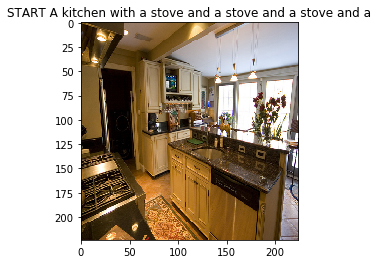

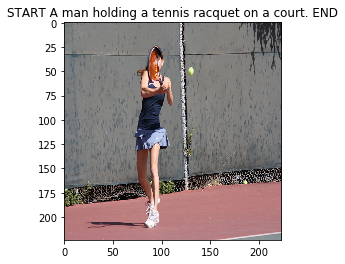

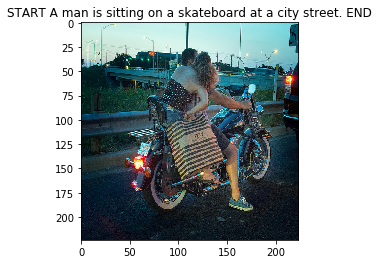

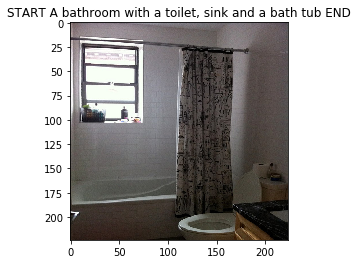

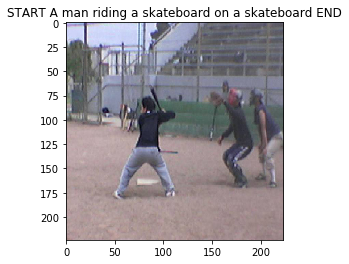

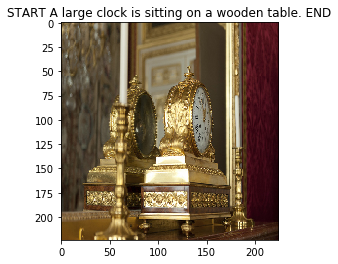

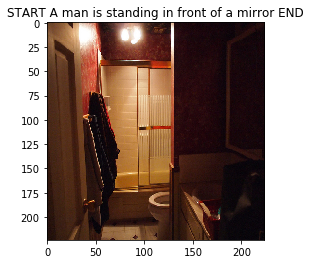

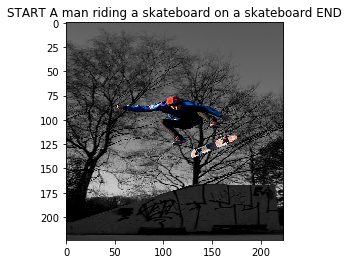

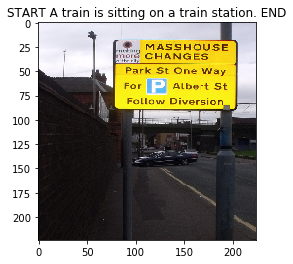

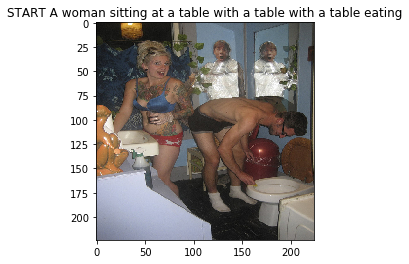

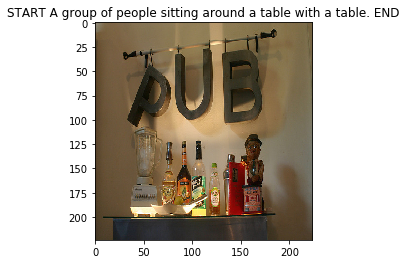

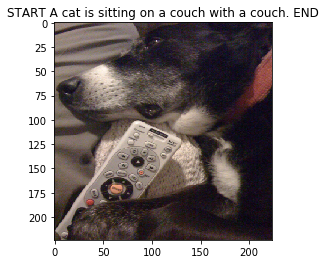

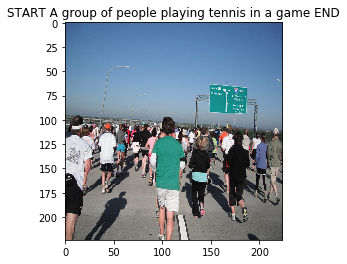

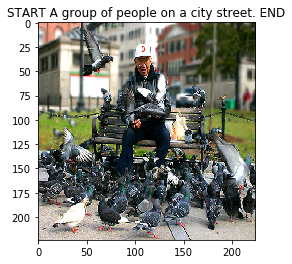

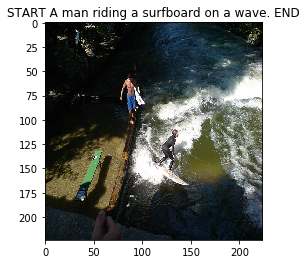

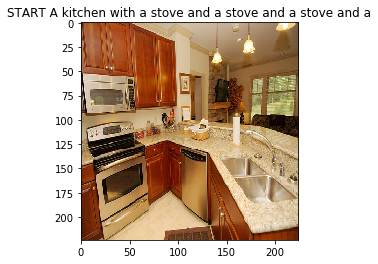

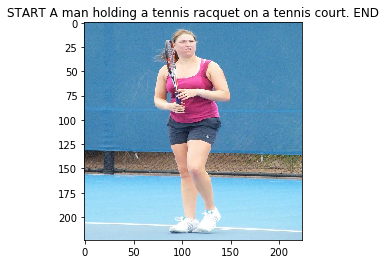

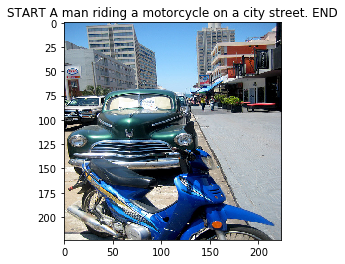

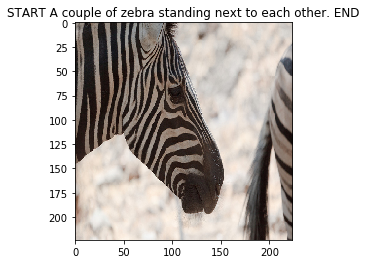

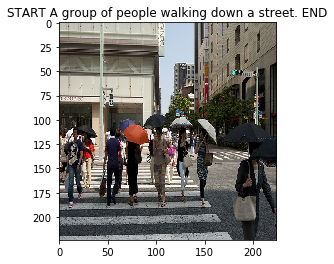

In [209]:
plot_predictions(images,titles = predicted_captions)

In [111]:
bleu_scores = [nltk.translate.bleu_score.sentence_bleu([test_captions[i]], predicted_captions[i]) for i in range(10)]

In [107]:
np.average(bleu_scores)

0.27387421978858323

In [191]:
def most_common_words(captions,word_limit):
    
    sentences = [caption.split() for caption in captions]
    words = []
    for word in sentences:
        words.extend(word)

    counter=collections.Counter(words)
    return counter.most_common(word_limit)


In [202]:
common_words = most_common_words(predicted_captions,50)

In [203]:
common_words

[(u'a', 184),
 (u'START', 100),
 (u'A', 99),
 (u'END', 78),
 (u'on', 59),
 (u'and', 46),
 (u'with', 35),
 (u'of', 33),
 (u'man', 33),
 (u'in', 26),
 (u'sitting', 23),
 (u'group', 19),
 (u'is', 17),
 (u'skateboard', 16),
 (u'people', 15),
 (u'white', 15),
 (u'standing', 14),
 (u'riding', 13),
 (u'young', 12),
 (u'street.', 12),
 (u'table', 12),
 (u'table.', 11),
 (u'wooden', 11),
 (u'sink', 11),
 (u'to', 8),
 (u'field.', 8),
 (u'next', 8),
 (u'train', 8),
 (u'stove', 6),
 (u'woman', 6),
 (u'city', 6),
 (u'tennis', 6),
 (u'couch', 6),
 (u'red', 5),
 (u'kitchen', 5),
 (u'bathroom', 5),
 (u'cat', 5),
 (u'at', 5),
 (u'around', 4),
 (u'baseball', 4),
 (u'black', 4),
 (u'field', 4),
 (u'pizza', 4),
 (u'the', 4),
 (u'playing', 4),
 (u'walking', 3),
 (u'parked', 3),
 (u'elephants', 3),
 (u'bench', 3),
 (u'plate', 3)]

In [199]:
def search_images_by(searched_word,images,predicted_captions):
    found_indexes = [index for index, caption in enumerate(predicted_captions) if searched_word in caption.split()]
    return ([images[i] for i in found_indexes],[predicted_captions[i] for i in found_indexes])


In [206]:
searched_word = "cat"
(found_images,found_captions) = search_images_by(searched_word,images,predicted_captions)
print("Number of results = %d"%len(found_images))

Number of results = 5


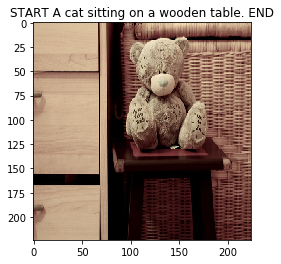

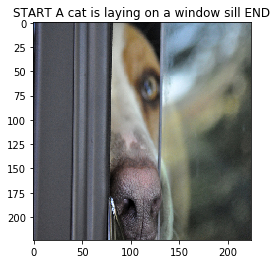

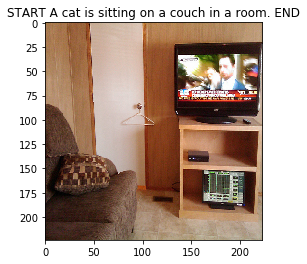

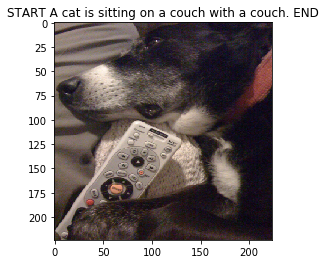

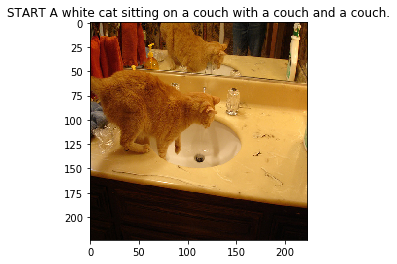

In [207]:
plot_predictions(found_images,found_captions)